# FEDOT framework
#### FEDOT version = 0.3.1

In [ ]:
pip install fedot==0.3.1

Below is a description of the FEDOT framework and its main functions, which can be used to solve various ML tasks, namely:

* Regression
* Classification
* Time series forecasting
* Clustering

FEDOT can construct complex composite models (consisting of multiple machine learning models and preprocessing operations) based on an evolutionary algorithm. Thus, it is possible to create pipelines for solving various tasks.

The structure of the FEDOT framework can be seen in the figure below:

![fedot_structure.png](../jupyter_media/fedot_structure/fedot_structure_03.png)

Figure 1. The structure of the FEDOT framework. The main modules of the library are shown.

As you can see from the picture there are two ways to start FEDOT:
1) API - allows you to run framework models in a few lines of code;
2) Low-level methods from the core - you can call methods by accessing the core directly. In this case, you will have to write more code, but more functionality opens up.

## Composite models

FEDOT has following abstractions:
* Operation - is a machine learning model or preprocessing operation or statistical models;
* Node - is a container in which the operation is placed. A single node can contain only one operation;
* Chain - is directed acyclic graph-like structure that contains several connected nodes. The analogue can be a computation graph from tensorflow, or simple workflow (from Apache Airflow, for instance). Chains are complex composite models. A single chain can consist of multiple nodes, or a single node.

![operation_node_chain.png](../jupyter_media/fedot_structure/operation_node_chain.png)

## Generate synthetic dataset for classification task

In [2]:
from fedot.utilities.synth_dataset_generator import classification_dataset
from sklearn.metrics import roc_auc_score as roc_auc

# Generate numpy arrays with features and target
features_options = {'informative': 1, 'redundant': 0,
                    'repeated': 0, 'clusters_per_class': 1}
x_data, y_data = classification_dataset(samples_amount=250,
                                        features_amount=3,
                                        classes_amount=2,
                                        features_options=features_options)

print(f'Features table shape: {x_data.shape}, type: {type(x_data)}')
print(f'Target vector: {y_data.shape}, type: {type(y_data)}')

Features table shape: (250, 3), type: <class 'numpy.ndarray'>
Target vector: (250,), type: <class 'numpy.ndarray'>


Prepare the necessary imports

In [3]:
import numpy as np

# Create chain
from fedot.core.chains.chain import Chain
from fedot.core.chains.node import PrimaryNode, SecondaryNode

# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum

# Dataclass for wrapping arrays into it
from fedot.core.data.data import InputData

# Type of the input data
from fedot.core.repository.dataset_types import DataTypesEnum

# Define classification task
task = Task(TaskTypesEnum.classification)

# Prepare data to train the model
input_data = InputData(idx=np.arange(0, len(x_data)), features=x_data,
                       target=y_data, task=task,
                       data_type=DataTypesEnum.table)

## Manual chain 

Below, we will try to set the chain manually, and obtain a prediction using it.

Manually create a chain of the following configuration:

![logit_scaling_lda.png](../jupyter_media/fedot_structure/logit_scaling_lda.png)

In [4]:
# Define chain 
node_logit = PrimaryNode('logit')
node_scaling = PrimaryNode('scaling')
node_logit = SecondaryNode('lda', nodes_from=[node_logit, node_scaling])
chain = Chain(node_logit)

# Fit it
chain.fit(input_data)

# Make prediction
predicted_output = chain.predict(input_data)
probs = np.array(predicted_output.predict)

# Check metric value
print(f'ROC AUC score on training sample: {roc_auc(y_data, probs):.3f}')

ROC AUC score on training sample: 0.941


This is how you learned the concept of chains in FEDOT.

But FEDOT can automatically construct such chains to solve the task.

Below are two examples for solving the classification task (with such chains) using API methods and using FEDOT.core function directly. Both examples, regardless of the way they interact, run an automatic machine learning algorithm.

## AutoML

### API example

Using the API allows you to find good solutions using a few lines of code, but on the other hand, this approach has less abilities for modification than using core-based methods.

*Due to the specifics of the jupiter notebooks format, in order not to overload the page with unnecessary logs, we do not show the cell output below.

In [ ]:
from fedot.api.main import Fedot

# Task selection, initialisation of the framework
fedot_model = Fedot(problem='classification', learning_time=1,
                    seed=20, verbose_level=4)

# During fit, the chain composition algorithm is started
pipeline = fedot_model.fit(features=x_data,
                           target=y_data)

In [6]:
prediction = fedot_model.predict_proba(features=x_data)
print(pipeline)
print(f'ROC AUC score on training sample: {roc_auc(y_data, prediction):.3f}')

{'depth': 3, 'length': 6, 'nodes': [xgboost, lda, bernb, lda, qda, scaling]}
ROC AUC score on training sample: 0.973


### Core-based example

We will transform the data into a specific format (InputData) for the algorithm launch.

In [7]:
import datetime
import numpy as np 

# Dataclass for wrapping arrays into it
from fedot.core.data.data import InputData

# Tasks to solve
from fedot.core.repository.tasks import Task, TaskTypesEnum

# Type of the input data
from fedot.core.repository.dataset_types import DataTypesEnum

# Repository with operations in the FEDOT
from fedot.core.repository.operation_types_repository import get_operations_for_task

# Chain of the FEDOT
from fedot.core.chains.chain import Chain

# Evolutionary algorithm classes 
from fedot.core.composer.gp_composer.gp_composer import GPComposerBuilder, GPComposerRequirements
from fedot.core.composer.optimisers.gp_comp.gp_optimiser import GPChainOptimiserParameters, GeneticSchemeTypesEnum
from fedot.core.repository.quality_metrics_repository import ClassificationMetricsEnum

Let's define the task that we plan to solve-classification

We will also wrap the data in a special structure-Input Data, where we will assign features, specify target, pass the data type (table) and the specified type of the task to be solved.

In [8]:
# Define classification task
task = Task(TaskTypesEnum.classification)

# Prepare data to train the model
input_data = InputData(idx=np.arange(0, len(x_data)), features=x_data,
                       target=y_data, task=task,
                       data_type=DataTypesEnum.table)

Now we have identified the data and the task within which we will look for a solution.

Next, we want to find a composite model (chain) of such a structure that predicts class labels as accurately as possible. We can determine from which models we can assemble such chains.

In [9]:
# The search of the models provided by the framework that can be used as nodes in a chain for the selected task
available_model_types = get_operations_for_task(task=task, mode='models')
available_model_types

['logit', 'lda', 'qda', 'dt', 'rf', 'mlp', 'knn', 'xgboost', 'bernb']

Let's set the metric that we will use during the evolution process, select "ROCAUC_penalty"

In [10]:
# The choice of the metric for the chain quality assessment during composition
metric_function = ClassificationMetricsEnum.ROCAUC_penalty

#### GPComposer

GPComposer is a genetic algorithm that allows you to search for optimal solutions by composing the chains of single machine learning models. 

Through GPComposerRequirements, we can set some hyperparameters to adjust the behavior of the evolutionary algorithm.

With the help of GPComposerRequirements, you can manage:
* types of models that can be inserted into primary nodes
* types of models that can be inserted into secondary nodes
* mutation probability
* crossover probability
* arity of directed acyclic graph (DAG)
* maximum depth of the found chain
* time to find a solution

In [11]:
# The choice and initialisation of the GP search
max_lead_time = datetime.timedelta(minutes=5)
composer_requirements = GPComposerRequirements(
    primary=available_model_types,
    secondary=available_model_types, 
    max_arity=3,
    max_depth=3, pop_size=10,
    num_of_generations=10,
    crossover_prob=0.8, 
    mutation_prob=0.8, 
    max_lead_time=max_lead_time)

Below we will define the genetic scheme of the algorithm. 

There are several schemes:
* steady_state - evolutionary scheme, also known as $(\mu+\lambda)$. New population is generated by using a selection operator which is applied to the union of the offspring and the previous population;
* generational - the offspring completely replaces the parent population;
* parameter_free - steady-state evolutionary scheme, but $\mu$ (population size) changes during evolution like the Fibonacci sequence and $\lambda$ always equals to the previous item of the sequence with respect to $\mu$.

For more information you can check [preprint](https://arxiv.org/abs/2103.01301).

We will also use the GPComposerBuilder structure, which allows you to set parameters in GPComposer.

In [ ]:
# GP optimiser parameters choice
scheme_type = GeneticSchemeTypesEnum.parameter_free
optimiser_parameters = GPChainOptimiserParameters(genetic_scheme_type=scheme_type)

# Create builder for composer and set composer params
builder = GPComposerBuilder(task=task).\
    with_requirements(composer_requirements).\
    with_metrics(metric_function).\
    with_optimiser_parameters(optimiser_parameters)

# Create GP-based composer
composer = builder.build()

# the optimal chain generation by composition - the most time-consuming task
chain_evo_composed = composer.compose_chain(data=input_data,
                                            is_visualise=True)

We got a chain of several machine learning models. But in the course of evolution, the hyperparameters of these models did not change. Now, within the given topology, we will optimize the hyperparameters.

*Due to the specifics of the jupiter notebooks format, in order not to overload the page with unnecessary logs, we do not show the cell output below.

In [ ]:
chain_evo_composed.fine_tune_all_nodes(loss_function=roc_auc,
                                       loss_params=None,
                                       input_data=input_data)

Check the metric

In [14]:
prediction = chain_evo_composed.predict(input_data)
print(f'ROC AUC score on training sample: {roc_auc(y_data, prediction.predict):.3f}')

ROC AUC score on training sample: 0.984


As you can see from the metric value, the model was well trained on the training sample. 

### Chain visualistion 

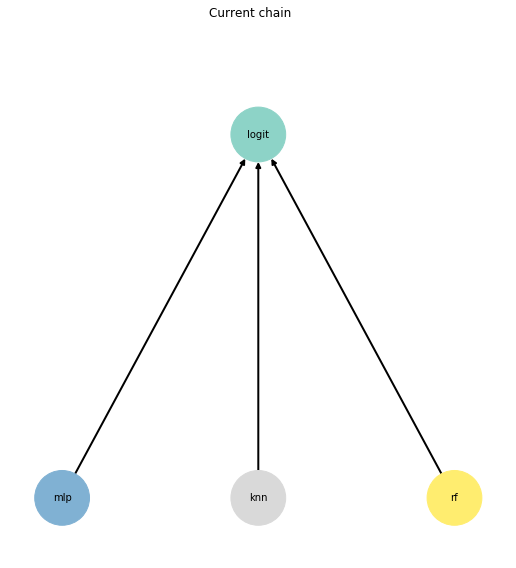

In [16]:
chain_evo_composed.show()

So, in this notebook, you learned how to run FEDOT for the classification task, both using the API and using more complex constructs from the core based on the functionality of the FEDOT framework.